以 VGG19 网络作为作为基础

In [2]:
#导入需要的模块
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import nn
import torch.functional as F
import torch.optim as optim

import torch.utils.data as Data

In [3]:
# 导入预训练的好的 VGG19 网络
from torchvision import models

vgg19 = models.vgg19(pretrained=True)

# 不需要网络分类器，仅仅使用卷积池化层
vgg = vgg19.features

# 将VGG19的网络权重冻结，不更新
for param in vgg.parameters():
    param.requires_grad_(False)

/home/yixiong_ren/anaconda3/envs/learntorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yixiong_ren/anaconda3/envs/learntorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/yixiong_ren/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
# 定义一个读取风格图像或内容图像的函数，并且将图像进行相应的转化
from torchvision import transforms
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    # 如果图片尺寸过大进行转化
    if max(image.size)>max_size:
        size = max_size
    else:
        size = max(image.size)

    # 如果指定了图像尺寸，将其转化为指定尺寸
    if shape is not None:
        size = shape

    # 使用transforms将图像转化为张量，并标准化
    in_transform = transforms.Compose(
        [transforms.Resize(size),
        transforms.ToTensor(),
        #标准化
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))]
    )
    image = in_transform(image)[:3, :, :].unsqueeze(dim=0)  #使用EGB通道
    return image

In [5]:
# 将函数转化为一个可视化的三维数组
def im_convert(tensor):
    image = tensor.data.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

content shape: torch.Size([1, 3, 400, 711])
style shape: torch.Size([1, 3, 400, 711])


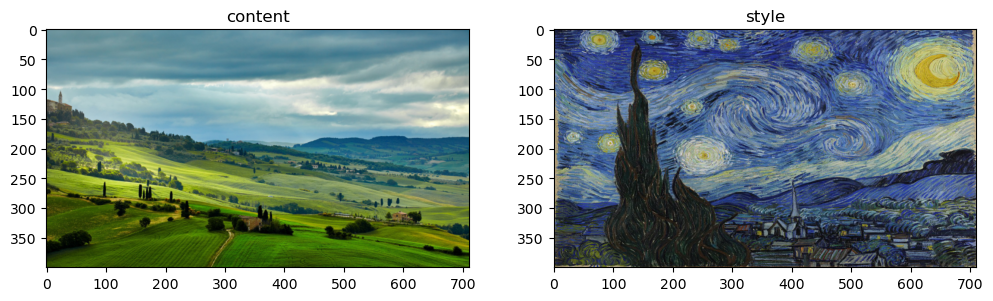

In [8]:
# 读取内容和风格图片
content = load_image('./data/content.jpg', max_size=400)    # 内容图片
print('content shape:', content.shape)

style = load_image('./data/style.jpg', shape=content.shape[-2:]) # 根据内容图片设置风格图片的大小
print('style shape:', style.shape)

# 可视化图像
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(im_convert(content))
ax1.set_title('content')

ax2.imshow(im_convert(style))
ax2.set_title('style')

plt.show()

In [14]:
def get_features(image, model, layers=None):
    # 将图片进行前向传播，并获取指定层的layers的特征映射输出
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'
        }
    features = {}
    x = image
    # model._modules是一个字典，保存着网络model每层信息
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features
            

In [16]:
# 定义 Gram 矩阵来比较是否具有相同的风格
def gram_matrix(tensor):
    _, d, h, w = tensor.size() 
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [21]:
# 计算在第一次训练之前的内容特征和风格特征
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True)

In [24]:
# 进行图像风格迁移
#定义每个样式的权重
style_weights = {
            'conv1_1':1.,
            'conv2_1':0.75,
            'conv3_1':0.2,
            'conv4_1':0.2,
            'conv5_1':0.2
        }
alpha = 1
beta = 1e6
content_weight = alpha
style_weight = beta

In [29]:
import time
show_every = 1000

# 保存损失
total_loss_all = []
content_loss_all = []
style_loss_all = []

# 使用 adam 优化器
optimizer = optim.Adam([target], lr=0.0003)
steps = 5000
t0 = time.time()
for i in range(1, steps+1):
    target_features = get_features(target, vgg) # 获取特征
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)  #计算内容损失

    # 计算风格损失，将每层的 gram 矩阵结果相加
    style_loss = 0 
    for layer in style_weights:
        # 计算生成图像的风格表示
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape

        # 获取风格图像在每层的 gram 矩阵
        style_gram = style_grams[layer] 

        # 计算风格差异
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d*h*w)

    # 计算内容损失与风格损失的加权和
    total_loss = content_weight * content_loss + style_weight*style_loss

    # 记录三种损失
    content_loss_all.append(content_loss.item())
    style_loss_all.append(style_loss.item())
    total_loss_all.append(total_loss.item())

    # 更新需要生成的目标图像
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # 输出迭代一定次数之后的图像
    if i % show_every == 0:
        print('total loss', total_loss.item())
        print('use time', (time.time() - t0)/3600, 'hour')
        newim = im_convert(target)
        #plt.title('Iteration:'+str(i)+'times')
        #plt.show()

        result = Image.fromarray((newim * 255).astype(np.uint8))
        result.save('./data/result'+str(i)+'.bmp')


total loss 101642040.0
use time 0.0898161369562149 hour
total loss 28146400.0
use time 0.18032245251867507 hour
total loss 12708006.0
use time 0.27041568206416233 hour
total loss 7601504.5
use time 0.3603192616171307 hour
total loss 4811783.0
use time 0.4501254001590941 hour
total loss 2961114.25
use time 0.5396038724978764 hour
total loss 1768138.25
use time 0.6296644773085912 hour
total loss 1068513.625
use time 0.719443890452385 hour
total loss 665830.1875
use time 0.8093183055851194 hour
total loss 420040.0
use time 0.8993168647421731 hour
total loss 263979.59375
use time 0.9899825481573741 hour
total loss 165355.828125
use time 1.0793313666847018 hour
total loss 104672.0546875
use time 1.169655543035931 hour
total loss 68653.8515625
use time 1.2591981620258754 hour
total loss 47444.078125
use time 1.3485701243744956 hour
total loss 35202.49609375
use time 1.437603507505523 hour
total loss 28166.009765625
use time 1.5267920722564061 hour
total loss 24004.9140625
use time 1.61604459

KeyboardInterrupt: 

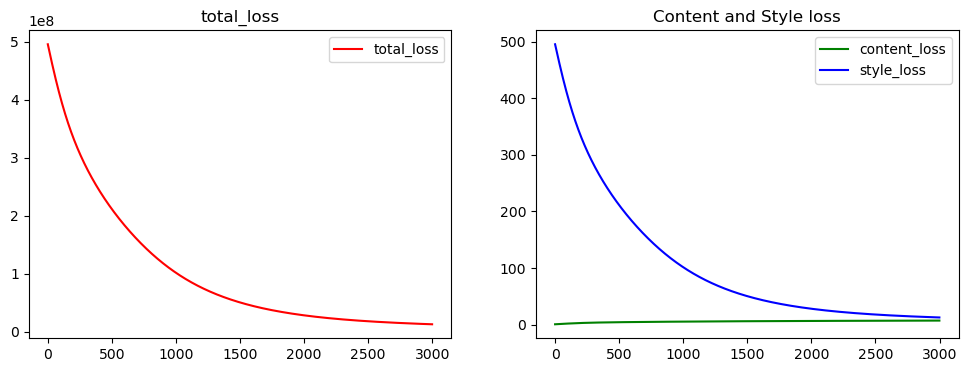

In [33]:
# 输出训练过程中的损失函数
number = 3000
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(total_loss_all[:number], 'r', label='total_loss')
plt.legend()
plt.title('total_loss')

plt.subplot(1, 2, 2)
plt.plot(content_loss_all[:number], 'g-', label='content_loss')
plt.plot(style_loss_all[:number], 'b-', label='style_loss')
plt.legend()
plt.title('Content and Style loss')

plt.show()